In [33]:
#!/usr/bin/env python

In [1]:
import BEWaveform as BEW

In [2]:
BE_parm_vec_1 = {
    'BE_wave_type': "sinc",
    'BE_w_center': 300000,
    'BE_w_width': 60000,
    'BE_amp': 1,
    'BE_smoothing': 150,
    'BE_phase_var': 0.01,
    'BE_window_adj': -0.11,
    'BE_ppw': 14,
    'BE_rep': 0
}

BE_parm_vec_2 = {
    'BE_wave_type': "sinc",
    'BE_w_center': 150000,
    'BE_w_width': 80000,
    'BE_amp': 2,
    'BE_smoothing': 150,
    'BE_phase_var': 0.01,
    'BE_window_adj': -0.15,
    'BE_ppw': 14,
    'BE_rep': 0
}


BE = BEW.BEWaveform(BE_parm_vec_1, BE_parm_vec_2)

In [3]:
BE_wave, BE_band = BE.build_BE()

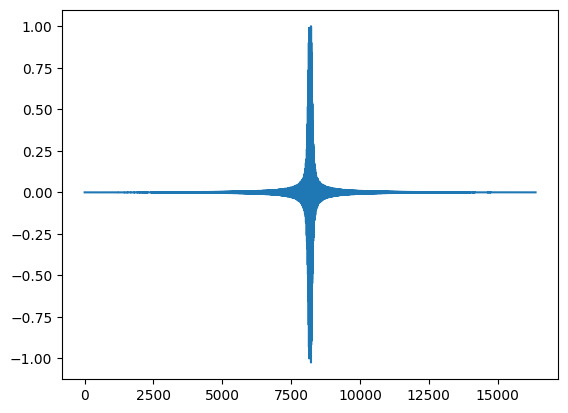

In [4]:
import matplotlib.pyplot as plt

plt.plot(BE_wave)

TypeError: 'int' object is not subscriptable

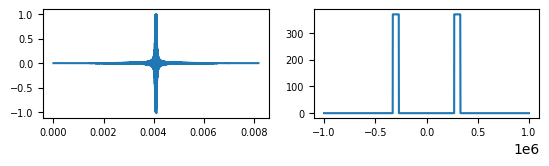

In [5]:
BE.BEPS_wave_build()

In [7]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

#global DAQ_platform_cond, BE_parm_vec_1, assembly_parm_vec, BE_parm_vec_2,SS_parm_vec, chirp_dir_cond, plot_cond_vec
#global code_section

#code section - checking for duplicates, building BEPS waveform, analying data
# DAQ_platform_cond
#BE_parm_vec_1 - ( BE_wave_type_1(0), BE_w_center_1(1),BE_w_width_1(2),BE_amp_1(3),BE_smoothing_1 (4),BE_phase_var_1(5),BE_window_adj_1 (6),BE_ppw_1(7),BE_rep_1(8))
#BE_parm_vec_2 - ( BE_wave_type_2(0), BE_w_center_2(1),BE_w_width_2(2),BE_amp_2(3),BE_smoothing_2 (4),BE_phase_var_2(5),BE_window_adj_2 (6),BE_ppw_2(7),BE_rep_2(8))
#assembly_parm_vec -  num_band_ring(0), par_ser_ring(1), meas_high_ring(2)
#SS_parm_vec - (SS_mode_ring [0], SS_max_offset_amp[1], SS_num_loops[2],SS_read_voltage[3], SS_start_V [4],SS_start_loop_amp [5], SS_final_loop_amp[6],SS_steps_per_cycle[7],SS_RW_ratio[8],SS_set_pulse_amp[9],SS_set_pulse_t[10],SS_smoothing[11],SS_step_t_req[12])
#bin_ind = lenght of bins_per_band
#chirp_dir_cond -(non-flip(0), flip(1))
#plot_cond_vec = 1

code_section = 1
DAQ_platform_cond = 0

BE_parm_vec_1 = {
    'BE_wave_type': "chirp",
    'BE_w_center': 70000,
    'BE_w_width': 20000,
    'BE_amp': 1,
    'BE_smoothing': 150,
    'BE_phase_var': 0.01,
    'BE_window_adj': -0.11,
    'BE_ppw': 14,
    'BE_rep': 0
}



# BE_parm_vec_1 = [3,70000, 20000, 1,150,0.01,-0.11, 14, 0]
# BE_parm_vec_2 = [3,400000, 40000, 2,150,0.01,-0.15, 14, 0]
# assembly_parm_vec = [0,1,1,1]
# SS_parm_vec = [0, 10,1,0,0,6,16,64,1,0,0,2E-6,0.01]
# chirp_dir_cond = 0
# plot_cond_vec = [1,1,1,0,1,1,1,1,0,1,0,0]
#bin_ind = lenght of bins_per_band


# def determine_AO_rate(BE_ppw, function_generator_freq = 0.01):
#     # coerce IO rate to acceptable value for PXI-5412
#     if DAQ_platform == 0:
#         AO_rate_req = BE_ppw / function_generator_freq  # requested frequency of the function generator
#         M, N = np.meshgrid(range(4), range(4))  # matrix of acceptable rates
#         av_mat = (5 ** M) * (2 ** N)
#         av_vec = av_mat.reshape(16)
#         av_vec = np.delete(av_vec, 15)
#         av_vec = np.sort(av_vec)
#         av_vec = 100E6 / av_vec
#         AO_rate = av_vec[np.argmin(abs(av_vec - AO_rate_req))]
#         SS_step_t = BE_ppw / AO_rate

#     # # coerce IO rate to acceptable value for PXI-6115
#     # if DAQ_platform_cond == 1:
#     #     AO_rate_req = BE_ppw / function_generator_freq  # requested frequency of the function generator
#     #     av_vec = 20E6 / np.arange(1, 1001)  # vector of acceptable rates
#     #     AO_rate = av_vec[np.argmin(abs(av_vec - AO_rate_req))]
#     #     SS_step_t = BE_ppw / AO_rate

#     return AO_rate, SS_step_t

def build_BE(BE_parm_vec, AO_rate, SS_step_t, chirp_direction = 0):
    BE_wave_type = BE_parm_vec[0]
    BE_w_center = BE_parm_vec[1]
    BE_w_width = BE_parm_vec[2]
    BE_amp = BE_parm_vec[3]
    BE_smoothing = BE_parm_vec[4]
    BE_phase_var = BE_parm_vec[5]
    BE_window_adj = BE_parm_vec[6]
    BE_ppw = 2**BE_parm_vec[7]
    BE_rep = 2**BE_parm_vec[8]

    w1 = BE_w_center - BE_w_width/2
    w2 = BE_w_center + BE_w_width/2

    if BE_wave_type == 3:
      chirp_t = SS_step_t / BE_rep
      t = np.arange(0, chirp_t, 1 / (AO_rate - 1))  # time vector
      m = (w2 - w1) / chirp_t / 2  # slope of frequency change
      w_chirp = m * t + w1  # vector for linear frequency change with time
      chirp_smoothing = 4 * chirp_t * BE_smoothing / 1E4  # smoothing factor for error function
      envelopea = (1 + erf((t - chirp_smoothing * 2) / chirp_smoothing)) / 2  # first half of erf window
      envelopeb = (1 + erf((t + chirp_smoothing * 2 - chirp_t) / chirp_smoothing)) / 2  # second half of erf window
      envelope = envelopea - envelopeb  # erf window
      A = envelope * np.sin(2 * np.pi * t * w_chirp)

      for k in range(int(np.log2(BE_rep))):
          A = np.concatenate((A, A))

      if chirp_direction == 0:
          BE_wave = A[::-1]
      if chirp_direction == 1:
          BE_wave = A
      BE_band = np.fft.fftshift(np.fft.fft(A))

    elif BE_wave_type == 2:
        N = int(np.log2(BE_ppw))
        t_max = SS_step_t
        IO_rate = 2**N / t_max
        bw = w2 - w1

        w_vec = np.arange(-IO_rate/2, IO_rate/2 + IO_rate/(2**N-1), IO_rate/(2**N-1))
        f_resolution = 1 / t_max
        bin_ind_1 = round(2**(N-1) + w1 / f_resolution)
        bin_ind_2 = round(2**(N-1) + w2 / f_resolution)
        bin_ind = np.arange(bin_ind_1, bin_ind_2 + 1)
        
        points_per_band = bw * t_max
        f_rate = bw / t_max

        x1 = np.arange(0, 1, 1 / (len(bin_ind) - 1))

        Yp_chirp1 = -1 * ((x1) ** 2) * bw * np.pi * t_max * 1
        Yp1 = -1 * ((x1) ** 2) * bw * np.pi * t_max * BE_phase_var
        sigma = BE_smoothing
        a = erf((w_vec - w1 - 2 * sigma) / sigma)
        b = erf((w_vec - w2 + 2 * sigma) / sigma)
        Ya = np.sqrt(2 ** N * IO_rate / bw) * 1 / 2 * (a - b)
        Yp = np.zeros_like(Ya)
        Yp[bin_ind] = Yp1
        Yp_chirp = np.zeros_like(Ya)
        Yp_chirp[bin_ind] = Yp_chirp1

        Y = Ya * np.exp(1j * Yp)
        Y_chirp = Ya * np.exp(1j * Yp_chirp)

        A = np.real(np.fft.ifft(np.fft.fftshift(Y)))
        A = np.roll(A, round((2**N) * (1 - BE_phase_var) / 2))

        B = np.real(np.fft.ifft(np.fft.fftshift(Y_chirp)))

        if 1:
            cut_fraction = (BE_rep - 1) / (2 * BE_rep)
            keep = slice(int(BE_ppw * cut_fraction) + 1, int(BE_ppw * (1 - cut_fraction)))
            A = A[keep]
            for k in range(int(np.log2(BE_rep))):
                A = np.concatenate((A, A))

        BE_wave = A / max(A)
        BE_band = np.fft.fftshift(np.fft.fft(A))

        BE_wave_chirp = B / max(B)
        BE_band_chirp = np.fft.fftshift(np.fft.fft(B))


    # Return the results (modify accordingly)
    return BE_wave, BE_band

def plot_BE_wave(fig_num, BE_wave, BE_band, w_ind_band, w_vec_full, SS_step_t):
  fh = plt.figure(fig_num)
  plt.clf()
  sph1a = plt.subplot(3, 2, 1)
  plt.plot(np.arange(0, SS_step_t, SS_step_t / (len(BE_wave) )), BE_wave)
  plt.axis('tight')
  sph1b = plt.subplot(3, 2, 2)
  plt.plot(w_vec_full, np.abs(BE_band))
  plt.axis('tight')
  sph1c = plt.subplot(3, 2, 5)
  ph1c = plt.plot(w_vec_full[w_ind_band], np.abs(BE_band[w_ind_band]), 'o-')
  plt.axis('tight')
  sph1d = plt.subplot(3, 2, 6)
  plt.plot(w_vec_full[w_ind_band], np.unwrap(np.angle(BE_band[w_ind_band])))
  plt.axis('tight')
  sph1a.tick_params(axis='both', which='both', labelsize=7)
  sph1b.tick_params(axis='both', which='both', labelsize=7)
  sph1c.tick_params(axis='both', which='both', labelsize=7)
  sph1d.tick_params(axis='both', which='both', labelsize=7)
  ph1c[0].set_markersize(1.5)
  fh.set_facecolor([1, 1, 1])


def BEPS_wave_build():
    num_band_ring = assembly_parm_vec[0]
    par_ser_ring = assembly_parm_vec[1]
    meas_high_ring = assembly_parm_vec[2]

    BE_wave_type_1 = BE_parm_vec_1[0]
    BE_w_center_1 = BE_parm_vec_1[1]
    BE_w_width_1 = BE_parm_vec_1[2]
    BE_amp_1 = BE_parm_vec_1[3]
    BE_smoothing_1 = BE_parm_vec_1[4]
    BE_phase_var_1 = BE_parm_vec_1[5]
    BE_window_adj_1 = BE_parm_vec_1[6]
    BE_ppw_1 = 2**BE_parm_vec_1[7]
    BE_rep_1 = 2**BE_parm_vec_1[8]

    BE_wave_type_2 = BE_parm_vec_2[0]
    BE_w_center_2 = BE_parm_vec_2[1]
    BE_w_width_2 = BE_parm_vec_2[2]
    BE_amp_2 = BE_parm_vec_2[3]
    BE_smoothing_2 = BE_parm_vec_2[4]
    BE_phase_var_2 = BE_parm_vec_2[5]
    BE_window_adj_2 = BE_parm_vec_2[6]
    BE_ppw_2 = 2**BE_parm_vec_1[7]  # set to be the same as BE wave 1
    BE_rep_2 = 2**BE_parm_vec_2[8]

    SS_mode_ring = SS_parm_vec[0]
    SS_max_offset_amp = SS_parm_vec[1]
    SS_num_loops = SS_parm_vec[2]
    SS_read_voltage = SS_parm_vec[3]
    SS_start_V = SS_parm_vec[4]
    SS_start_loop_amp = SS_parm_vec[5]
    SS_final_loop_amp = SS_parm_vec[6]
    SS_steps_per_cycle = SS_parm_vec[7]
    SS_RW_ratio = SS_parm_vec[8]
    SS_set_pulse_amp = SS_parm_vec[9]
    SS_set_pulse_t = SS_parm_vec[10]
    SS_smoothing = SS_parm_vec[11]
    SS_step_t_req = SS_parm_vec[12]

    # Determine IO rate
    AO_rate, SS_step_t = determine_AO_rate(BE_ppw_1, SS_step_t_req)
    AO_length = AO_rate * SS_step_t

    w_vec_full = np.arange(-AO_rate/2, AO_rate/2 + AO_rate/(AO_length-1), AO_rate/(AO_length-1))
    w1_1 = BE_w_center_1 - BE_w_width_1/2
    w2_1 = BE_w_center_1 + BE_w_width_1/2
    w1_2 = BE_w_center_2 - BE_w_width_2/2
    w2_2 = BE_w_center_2 + BE_w_width_2/2
    w_ind_band_1 = np.where((w_vec_full >= w1_1) & (w_vec_full <= w2_1))[0]
    w_ind_band_2 = np.where((w_vec_full >= w1_2) & (w_vec_full <= w2_2))[0]

    if BE_wave_type_1 >= 1:
      BE_wave_1, BE_band_1 = build_BE(BE_parm_vec_1, AO_rate, SS_step_t)
    
    BE_wave_1 = BE_wave_1 * BE_amp_1
    F_BE_wave_1 = np.fft.fftshift(np.fft.fft(BE_wave_1))
    F_BE_wave_1 = F_BE_wave_1[len(F_BE_wave_1)//2:]
    F2_BE_wave_1 = np.fft.fftshift(np.fft.fft(BE_wave_1**2))
    F2_BE_wave_1 = F2_BE_wave_1[len(F2_BE_wave_1)//2:]
    if plot_cond_vec[0] == 1:
        plot_BE_wave(1, BE_wave_1, BE_band_1, w_ind_band_1, w_vec_full, SS_step_t)

    if num_band_ring == 1:
      if BE_wave_type_2 >= 1:
          BE_wave_2, BE_band_2 = build_BE(BE_parm_vec_2, AO_rate, SS_step_t)
      BE_wave_2 = BE_wave_2 * BE_amp_2
      F_BE_wave_2 = np.fft.fftshift(np.fft.fft(BE_wave_2))
      F_BE_wave_2 = F_BE_wave_2[:len(F_BE_wave_2)//2]
      if plot_cond_vec[0] == 1:
          plot_BE_wave(2, BE_wave_2, BE_band_2, w_ind_band_2, w_vec_full, SS_step_t)
      
    # Build SS waveform

  
  
    #return BEPS_wave, SS_parm_out, SS_read_vec, SS_write_vec



if code_section == 1:
    #code_section
    #BEPS_wave, SS_parm_out, SS_read_vec, SS_write_vec = BEPS_wave_build()
    BEPS_wave_build()

    plt.figure(2000)
    plt.plot(BEPS_wave[0:100000])

    if DAQ_platform_cond == 0:
        BEPS_wave = BEPS_wave / 10

    AO_length = len(BEPS_wave)
    SS_parm_out[0] = len(bin_ind)
    bins_per_band = len(bin_ind)
    BEPS_wave2 = BEPS_wave


NameError: name 'assembly_parm_vec' is not defined

In [ ]:
SS_parm_vec[12]

0.01